In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt

import IPython

cols = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
        'Acceleration', 'Model Year', 'Origin', 'Name']

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
auto = pd.read_csv(url, names=cols, na_values = "?", comment = '\t', skipinitialspace=True, delim_whitespace=True)
auto

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger


##### Exploratory Data Analysis

In [2]:
auto.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


##### Drop car name attribute

In [3]:
auto = auto.drop(['Name'], axis=1)

##### Clean dataset and fix missing values

In [4]:
auto.isnull().sum()
condition= auto[auto["Horsepower"].isnull()][["Cylinders", "Horsepower"]] # selects cylinders where horsepower is null
cylinder_number = condition.Cylinders.unique() #selects single values cylinder numbers

ch= auto.groupby("Cylinders")["Horsepower"].mean().reset_index(name='Horsepower') #average of horsepower by respective cylinders
ch_new = ch[ch["Cylinders"].isin(cylinder_number)].round(2) #only selects average of cylinder_number indicated to be nan above
avg_dict =dict(zip(ch_new['Cylinders'], ch_new['Horsepower'])) #assigning avg of cylinders of respective cylinders in a dict

bool_mask = auto['Horsepower'].isna()
auto.loc[bool_mask, 'Horsepower'] = auto.loc[bool_mask, 'Cylinders'].map(avg_dict) #fill in average of respective rows according to cylinder number

In [5]:
X= auto.drop(['MPG'], axis=1)

#assign MPG to the variable, y
y = auto.iloc[:, 0:1]

##### Split data into train and test sets

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=42)

##### Scale data

In [7]:
from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler().fit(X_train)
X_train = scaler2.transform(X_train)
X_test = scaler2.transform(X_test)

### Poor model

In [8]:
#create a fully connected neural network
a_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[7]),
    keras.layers.Dense(54, activation="relu"),
    keras.layers.Dense(54, activation="relu"),
    keras.layers.Dense(1)])

##### Overview of model

In [9]:
a_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 54)                432       
_________________________________________________________________
dense_1 (Dense)              (None, 54)                2970      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 55        
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
_________________________________________________________________


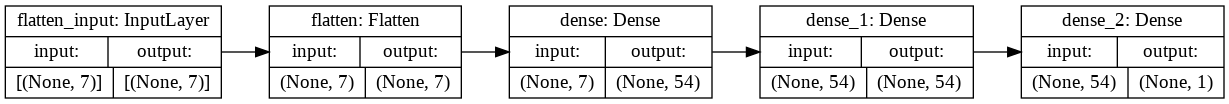

In [10]:
keras.utils.plot_model(a_model, "fd.png", show_shapes=True, rankdir='LR')

##### Establish loss, optimizer and metrics

In [47]:
#establish loss, optimizer and metrics
opt = tf.keras.optimizers.SGD(learning_rate= 0.09, momentum=0.1)

a_model.compile(loss="mean_absolute_error",
                optimizer=opt,
                metrics=['mape'])

In [48]:
history = a_model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    verbose=0, epochs=100)

#make prediction
poor_result = a_model.predict(X_test)

##### Evaluate model

In [49]:
train_loss, train_mse = a_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mse = a_model.evaluate(X_test, y_test, verbose=0)

train_mse, test_mse

(8.61746597290039, 10.622640609741211)

##### Visualize model metrics

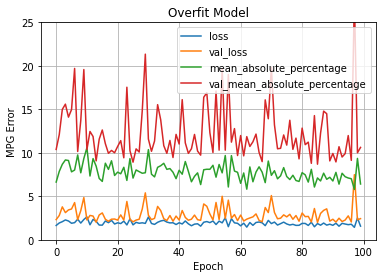

In [50]:
plt.plot(figsize=(30, 20))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['mape'], label='mean_absolute_percentage' )
plt.plot(history.history['val_mape'], label='val_mean_absolute_percentage')

plt.legend()
plt.ylim([0, 25])
plt.xlabel('Epoch')
plt.ylabel('MPG Error')
plt.title("Overfit Model")
plt.grid(True)
plt.show()

## Better model

In [15]:
b_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[7]),
    keras.layers.Dense(54, activation="relu"),
    keras.layers.Dense(54, activation="relu"),
    keras.layers.Dense(1)])

##### Model overview

In [16]:
b_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 54)                432       
_________________________________________________________________
dense_4 (Dense)              (None, 54)                2970      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 55        
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
_________________________________________________________________


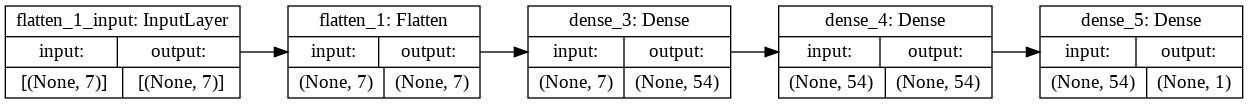

In [17]:
keras.utils.plot_model(b_model, "fe.png", show_shapes=True, rankdir='LR')

##### Establish loss, optimizer and metrics

In [18]:
b_model.compile(loss="mean_absolute_error",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['mape'])

Fit model

In [19]:
b_history = b_model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    verbose=1, epochs=100)

Epoch 1/100
7/7 [==============================] - 1s 33ms/step - loss: 23.5265 - mape: 99.3192 - val_loss: 23.1199 - val_mape: 97.9012
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 23.0945 - mape: 97.1708 - val_loss: 22.6668 - val_mape: 95.7137
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 22.6429 - mape: 94.9917 - val_loss: 22.1642 - val_mape: 93.3231
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 22.1188 - mape: 92.5178 - val_loss: 21.5543 - val_mape: 90.4405
Epoch 5/100
7/7 [==============================] - 0s 10ms/step - loss: 21.4831 - mape: 89.4948 - val_loss: 20.8043 - val_mape: 86.8806
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 20.6997 - mape: 85.7303 - val_loss: 19.8766 - val_mape: 82.4621
Epoch 7/100
7/7 [==============================] - 0s 9ms/step - loss: 19.7307 - mape: 81.0777 - val_loss: 18.7200 - val_mape: 76.8826
Epoch 8/100
7/7 [==============================] -

Make a prediction

In [20]:
better_result = b_model.predict(X_test)

Evaluate model

In [21]:
train_loss, train_mape = b_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mape = b_model.evaluate(X_test, y_test, verbose=0)
test_loss, test_loss

(1.920820713043213, 1.920820713043213)

Visualize model metrics

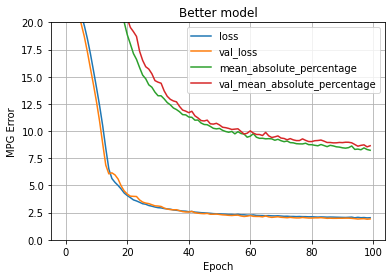

In [24]:
plt.plot(figsize=(30, 20))
plt.plot(b_history.history['loss'], label='loss')
plt.plot(b_history.history['val_loss'], label='val_loss')
plt.plot(b_history.history['mape'], label='mean_absolute_percentage' )
plt.plot(b_history.history['val_mape'], label='val_mean_absolute_percentage')

plt.legend()

plt.ylim([0, 20])
plt.title("Better model")
plt.xlabel('Epoch')
plt.ylabel('MPG Error')
plt.grid(True)
plt.show()